# EDSA - Climate Change Belief Analysis
#### Classification_TS3_DSFT21
------------------------------

<img src="images/Adaptacion_746x419.jpg"
     style="float: center; padding-bottom=0.5em"
     width=600px/>   
-------------------------------

## Table of Contents

1. <a href ="#1.-Challenge-description">Challenge description</a>
2. <a href ="#2.-Introduction">Introduction</a>
3. <a href ="#3.-Importing-Libraries">Importing Libraries</a>
4. <a href ="#4.-Importing-Data">Importing Data</a>
5. <a href ="#5.-Data-Preprocessing">Data Preprocessing</a>
6. <a href ="#6.-Exploratory-Data-Analysis">Exploratory Data Analysis</a>


# 1. Challenge description

Many companies are built around lessening one's environmental impact or carbon foot print. They offer products and services that are environmentally friendly and sustainable, in line with their values and ideals. They would like to determine how people perceive climante change and whether or not they belive it is a real threat. This would add to their market research efforts in gaugin how their product/service may be received.

With this context, EDSA is challending us during the Classification Sprint with the task of creating a Machine Learning mode that is able to classify whether or not a person believes in climate change, based on their novel tweet data.

Providing an accurate and robust solution to the task gives companies access to a broad base of consumer sentiment, spanning multiple demographic and geographic categories - thus increasing their insights and informing future marketing strategies.


# 2. Introduction

To achieve this, we shall perform preprocessing of the data, statistical and exploratory data analysis, construct multiple machine learning models, train our models with regards to the sentiment expressed by the user and of course testing our model on unseen data to verify the validity of our model.

# 3. Importing Libraries

In this notebook we shall be importing various python libraries to assist with constructing our classification model.

In [1]:
import nltk

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import re
from string import punctuation
from nltk.tokenize import TreebankWordTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec, KeyedVectors
import gensim.downloader as api

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE



# set plot style
sns.set(style = 'whitegrid')

C:\Users\nknhl\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
#Downloading NLTK Corpora
nltk.download(['punkt','stopwords'])

#Downloading wordnet for lemmatisation
nltk.download('wordnet')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nknhl\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nknhl\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nknhl\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [25]:
# from comet_ml import Experiment
# experiment = Experiment(
#     api_key="fJhgBq5xlPQoL6zHHWeLLh8w2",
#     project_name="edsa-classification-ts3",
#     workspace="nkonyanihlulani")

## 4. Importing Data

In [2]:
#Training set
train_df = pd.read_csv('data/train.csv')
#Test set
test_df = pd.read_csv('data/test.csv')

## Data Overview

Our training set consist of 3 columns:
* The sentiment : Indicates the sentiment of the tweet message
* message : The body of the tweet
* tweetid : Twitter unique id

In [3]:
train_df.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


We look at the top rows of our data to the see the features as well as the types of data we are working with.

In [4]:
test_df.head()

,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326
2,"The scary, unimpeachable evidence that climate...",224985
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928


Let us get the dimensions of our data to figure out how many observations we have.

In [5]:
np.shape(train_df)

(15819, 3)

We have 15 819 Observations in our data.

Let us get the types of sentiments that are there and their descriptions.

In [6]:
list(train_df['sentiment'].unique())

[1, 2, 0, -1]

There are three class namely :
* 1 Pro: the tweet supports the belief of man-made climate
* 2 News: the tweet links to factual news about climate change
* 0 Neutral: the tweet neither supports nor refutes the belief of man-made climate change
* -1 Anti: the tweet does not believe in man-made climate change

Now Let's obtain the counts of each class of sentiments and plot them on a bar graph

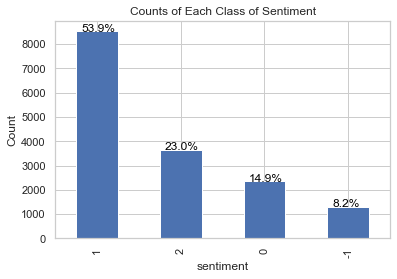

In [7]:
ax = train_df['sentiment'].value_counts().plot(kind = 'bar', 
                                          title = 'Counts of Each Class of Sentiment',
                                          xlabel = 'sentiment', 
                                          ylabel = 'Count')
n_obs = [i.get_height() for i in ax.patches]
total = sum(n_obs)

for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x()+0.06, i.get_height()+0.5, \
            str(round((i.get_height()/total)*100, 1))+'%', fontsize=12,
                color='black')

From the figure above, we observed that we have unbalanced classes. 
* The majority of tweets (53.9%) support the belief of man-made climate change. 
* 23% consist of factual news regarding climate change. 
* 14.9% are neutral about man-made climate change
* 8.2% don't believe in man-made climate change

## 5. Data Preprocessing

### 5.1. Noise Removal

Retrieving Base Forms involves taking words and generating their root form. One should always be caref There are 2 primary techniques for text normalisation namely:

Stemming
Lemmatization
N.B. Should exercise caution because many times the context of a word is lost when itis converted to its base form.

We will be using Lemmatization although it's a bit slower than stemming


In [8]:
def noise_remover_1(series):
    """This function takes in a pandas series with text data and return a clean column"""
    
    #removing urls
    pattern_url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
    res = series.replace(to_replace = pattern_url, value = '', regex = True)
    
    #mentions
    mentions = r'@[\w]*'
    res = res.replace(to_replace = mentions, value = '', regex = True)
    
    #hashtags
    hashtags = r'#[\w]*'
    res = res.replace(to_replace = hashtags, value = '', regex = True)
    
    #Punctuation
    res = res.apply(lambda x: ''.join(i for i in x if i not in punctuation))
    
    #lowercase
    res = res.str.lower()
    
    #remaining non-alphabetic numbers
    res = res.str.replace('[^a-z]', ' ',regex = True)
    
    #removing extra spaces
    res = res.apply(lambda x: re.sub(' +',' ',x))
    
    #Tokenization
    tokeniser = TreebankWordTokenizer()
    res_2 = res.apply(tokeniser.tokenize)
    
    #Stop word Removal
    lemmatizer = WordNetLemmatizer()
    res_2 = res_2.apply(lambda y: [lemmatizer.lemmatize(i) for i in y]) 
    
    #making the 1_st column to match the second
    res = res_2.apply(lambda a: ' '.join([i for i in a]))
    
    return res,res_2

In [9]:
train_df['clean_message'], train_df['tokens']  = noise_remover_1(train_df['message'])


In [10]:
train_df.head()

,sentiment,message,tweetid,clean_message,tokens
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,polyscimajor epa chief doesnt think carbon dio...,"[polyscimajor, epa, chief, doesnt, think, carb..."
1,1,It's not like we lack evidence of anthropogeni...,126103,it not like we lack evidence of anthropogenic ...,"[it, not, like, we, lack, evidence, of, anthro..."
2,2,RT @RawStory: Researchers say we have three ye...,698562,rt researcher say we have three year to act on...,"[rt, researcher, say, we, have, three, year, t..."
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,wired wa a pivotal year in the war on climate ...,"[wired, wa, a, pivotal, year, in, the, war, on..."
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,rt it and a racist sexist climate change denyi...,"[rt, it, and, a, racist, sexist, climate, chan..."


## 6. Exploratory Data Analysis

Now let's us study the distribution of the length of the words
* First we obtained a list containing all the words
* We obtained the lenth of each word and counted the number of times the word appears in our list
* we grouped frequencies by lenght and summed them up.

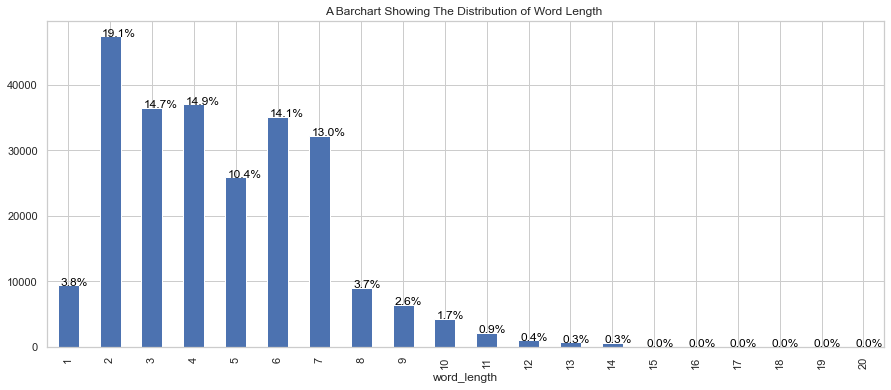

In [11]:
word_list =  train_df['tokens'].values
all_words_ls=[word_list[i][j] for i in range(len(word_list)) for j in range(len(word_list[i]))]
word_length_each =pd.DataFrame([[len(i),all_words_ls.count(i)] for i in set(all_words_ls)], 
                               columns = ['word_length','frequency'])


word_length_freq = word_length_each.groupby('word_length')['frequency'].sum().head(20).plot(kind ='bar', 
                                                                                           title = "A Barchart Showing The Distribution of Word Length ", 
                                                                                           figsize = (15,6))
n_obs = [i.get_height() for i in word_length_freq.patches]
total = sum(n_obs)

for i in word_length_freq.patches:
    # get_x pulls left or right; get_height pushes up or down
    word_length_freq.text(i.get_x()+0.06, i.get_height()+0.5, \
            str(round((i.get_height()/total)*100, 1))+'%', fontsize=12,
                color='black')

The lengths of the words ranged from 1-70, to obtain a better visualisation we limited the domain to words of lengths 1-2The length of the words appears to be positively skewed. We can expect the data to contain outliers to the right of the distribution. Most words lengths (78.4%) lies between 3-8,with the peak being 7.

We investigated words with lengths greater than 20 and the outcome is displayed below

In [12]:
greater_than_20_ls = [i for i in all_words_ls if len(i)>20]
greater_than_20_df =pd.DataFrame(greater_than_20_ls,columns =['more_than_20_char'])
greater_than_20_df

,more_than_20_char
0,technologysehipnotize
1,housesufosangelsbigfoot
2,nationalinternational
3,hahahahahahaahahahahahahaahahahaha
4,businessampacademician
5,politiciansscientists
6,affiliationagesexnationality
7,capsgtdrillingextracting
8,channelsfeeddigestcomnewsid
9,emotionalpsychological


From the above,we saw the words are nonsensical (mashup of words). And since they form small part of our sample we decided to remove them.

In order to identify the most common words tweeted, we plotted the wordcloud of all the words in our clean corpus. A bigger font implies higher frequency.

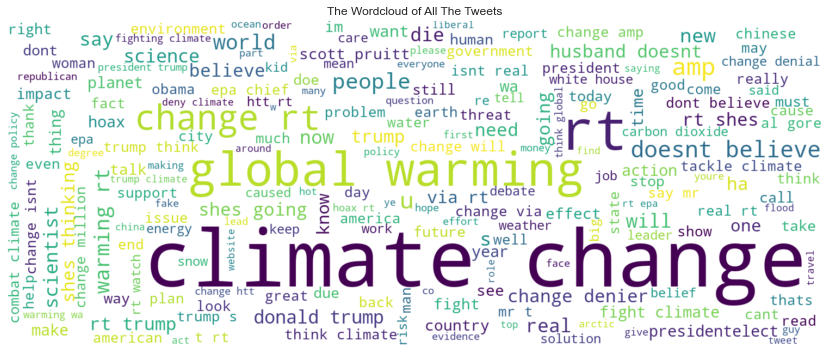

In [56]:
all_words = ' '.join([text for text in train_df['clean_message']])

wordcloud = WordCloud(width=1500, height=600,  background_color='white').generate(all_words)

plt.figure(figsize=(15, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('The Wordcloud of All The Tweets')
plt.show()

From The above we can see that our data still has a bit of noise. We might need to remove words of length less than 3.



We then obtained the most occurring words tweets that do not believe in man-made climate change

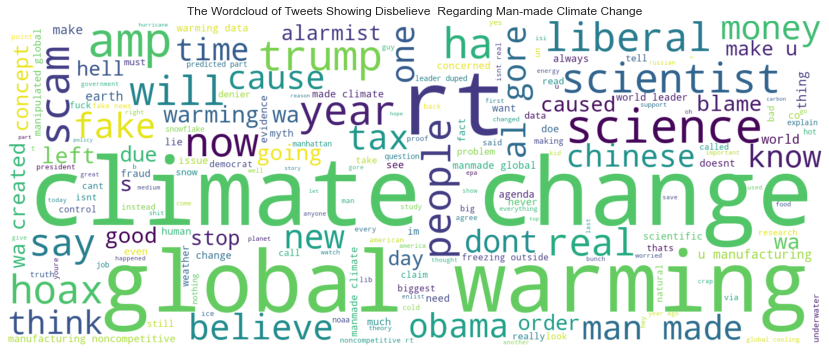

In [57]:
neg_words = ' '.join([text for text in train_df['clean_message'][train_df['sentiment'] == -1]])

wordcloud = WordCloud(width=1500, height=600,  background_color='white').generate(neg_words)

plt.figure(figsize=(15, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('The Wordcloud of Tweets Showing Disbelieve  Regarding Man-made Climate Change')
plt.show()

We obtained the most frequently used words to tweets that displayed belief in man-made climate change

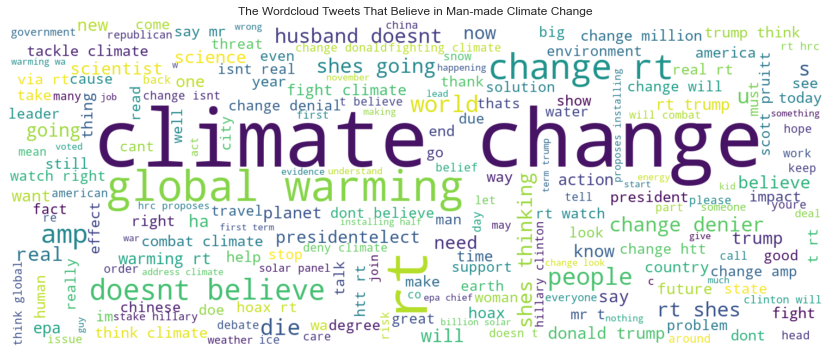

In [58]:
pro_words = ' '.join([text for text in train_df['clean_message'][train_df['sentiment'] == 1]])

wordcloud = WordCloud(width=1500, height=600,  background_color='white').generate(pro_words)

plt.figure(figsize=(15, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('The Wordcloud Tweets That Believe in Man-made Climate Change')

plt.show()

Neutral

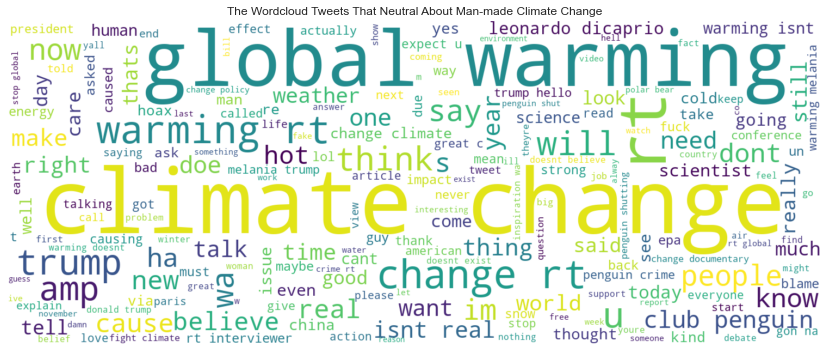

In [59]:
neutral_words = ' '.join([text for text in train_df['clean_message'][train_df['sentiment'] == 0]])

wordcloud = WordCloud(width=1500, height=600,  background_color='white').generate(neutral_words)

plt.figure(figsize=(15, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('The Wordcloud Tweets That Neutral About Man-made Climate Change')
plt.show()

Factual News about man-made cimate change

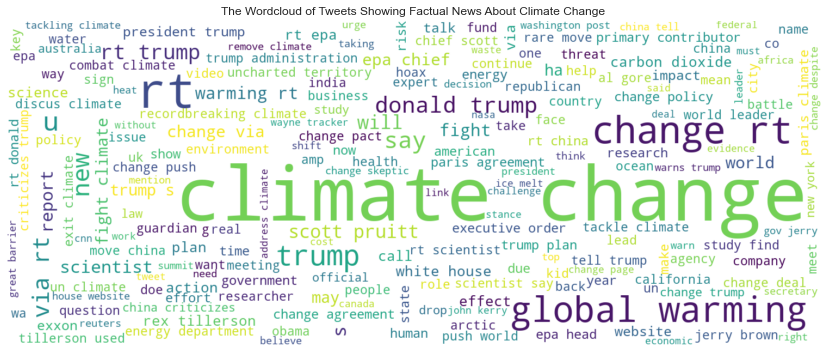

In [18]:
news = ' '.join([text for text in train_df['clean_message'][train_df['sentiment'] == 2]])

wordcloud = WordCloud(width=1500, height=600,  background_color='white').generate(news)

plt.figure(figsize=(15, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('The Wordcloud of Tweets Showing Factual News About Climate Change ')
plt.show()

Our analysis above indicated that we might need to remove words with length 1 and 2. Words such as rt  and $\tilde{a}$. So we limited our analysis to these lengths to see the most frequenty occuring words.


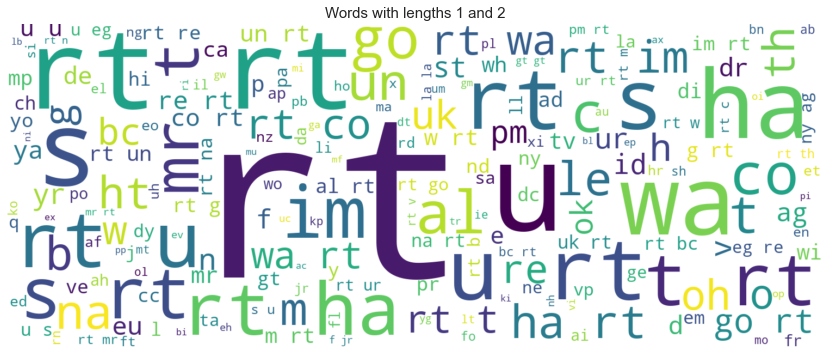

In [19]:
len_12 = ' '.join([i for i in all_words_ls if len(i)<3])
neg_words = ' '.join([text for text in train_df['clean_message'][train_df['sentiment'] == 2]])

wordcloud = WordCloud(width=1500, height=600,  background_color='white').generate(len_12)
plt.figure(figsize=(15, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('Words with lengths 1 and 2', fontsize=15)
plt.axis('off')
plt.show()

The words above were regarded as noise. We decided to remove all the words with a length less than 3.

In [13]:
less_than_3 = [i for i in all_words_ls if len(i)<3]

In [14]:
def text_cleaner_2(col):
    
    """This function takes a column with tokens and removes words with lengths greater than 20 or lengths less than 3"""
    
    # removing words greater than 20 in length
    res_1 = col.apply(lambda x : [i for i in x if i not in greater_than_20_ls])
    
    #removing words less than three in size
    res_1 = res_1.apply(lambda x : [i for i in x if i not in less_than_3])
    
    #making the other column match the new tokens
    res_2 = res_1.apply(lambda a: ' '.join([i for i in a]))
    
    return res_2,res_1

In [15]:
train_df['clean_message'],train_df['tokens'] = text_cleaner_2(train_df['tokens'])

In [16]:
train_df.head()

,sentiment,message,tweetid,clean_message,tokens
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,polyscimajor epa chief doesnt think carbon dio...,"[polyscimajor, epa, chief, doesnt, think, carb..."
1,1,It's not like we lack evidence of anthropogeni...,126103,not like lack evidence anthropogenic global wa...,"[not, like, lack, evidence, anthropogenic, glo..."
2,2,RT @RawStory: Researchers say we have three ye...,698562,researcher say have three year act climate cha...,"[researcher, say, have, three, year, act, clim..."
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,wired pivotal year the war climate change,"[wired, pivotal, year, the, war, climate, change]"
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,and racist sexist climate change denying bigot...,"[and, racist, sexist, climate, change, denying..."


## 7. Feature Extraction
In this section we tried different techniques for feature extraction, we tried each of the following techniques to see the one that gives us the best performance:

7.1. <a href ="#7.1.-Bag-of-Words">Bag of Words</a>

7.2. <a href ="#7.2.-TF-IDF">TF-IDF</a>



### 7.1. Bag of Words

Bag of words ignores any information about the ordering or the structure of the words in our corpus. Its only concern is the occurence of the word(s). It takes in a list containing all the clean words in our corpus and returns a dictionary containing the unique words as keys and their frequencies as values. The algorithm can be configured to take in single words or take a group of words (those attained through Ngrams. The image below shows the former but the same rules apply for $n>1$.

<img src="images/bag_of_word1.png"
     style="float: center; padding-bottom=0.5em"
     width=600px/>
     
For each and every row, the text is going to be vectorized by in this form:
<img src="images/bag_of_word3.png"
     style="float: center; padding-bottom=0.5em"
     width=600px/>


We will start with by considering single words

In [17]:
X = train_df['clean_message'].values
y = train_df['sentiment'].values

X_train1, X_val1,y_train1,y_val1 = train_test_split(X,y,test_size=0.2,random_state = 2)


In [18]:

vectorizer_1 = CountVectorizer(ngram_range=(1,1))

X_train_1gram =  vectorizer_1.fit_transform(X_train1).toarray()

X_val_1gram = vectorizer_1.transform(X_val1).toarray()

In [19]:
np.shape(X_train_1gram)

(12655, 11773)

THen consider bigrams

In [20]:
vectorizer_2 = CountVectorizer(ngram_range=(2,2), max_features = 15000)

X_train_2gram =  vectorizer_2.fit_transform(X_train1).toarray()

X_val_2gram = vectorizer_2.transform(X_val1).toarray()

### 7.2. TF-IDF

Term Frequency Inverse Document Frequency is a statistic that measures how important a a word is in a document while taking into consideration how many times it appears in other documents.

The reason for doing this is:
* If a word appears in a document then it is more likely to contain information about that document
* If a word is scattered throughout the whole document it is unlikely to contain information distinguishing the various documents


The calculation tf-idf can be broken into 4 parts:
1. Calculate the term frequency: 

$$ft(w,d) = \log{\left[1+f(w,d)\right]}$$
*  Where: 
 * $f(w,d)$ measures how frequently a word $w$ appears in document $d$
2. Calculate the inverse term frequency:
$$idf(w,D) = \log{\left[\frac{N}{f(w,D)}\right]}$$
* Where:
 * $N$ is the number of documents in our corpus
 * $D$ is a set containing all the documents in our corpus
 * $f(w,D)$ is the number documents that contain $w$.
3. We combine the above to form tf-idf - Term Frequency - Inverse Document Frequency:
$$tf-idf = tf(w,d)\times idf(w,D)$$

4. Finally, we get a vectorized vesion of all the documents in our corpus


Drawbacks:
* Not able to capture semantics

<img src="images/tf-idf.png"
     style="float: center; padding-bottom=0.5em"
     width=600px/>

We start with N = 1

In [25]:
vectorizer_3 = TfidfVectorizer()
X_train_tfidf1 = vectorizer_3.fit_transform(X_train1).toarray()
X_val_tfidf1 = vectorizer_3.transform(X_val1).toarray()

In [50]:
np.shape(X_train_tfidf1)

(12655, 11773)

We consider bigrams

In [33]:
vectorizer_4 = TfidfVectorizer(ngram_range = (2,2), max_features = 15000)
X_train_tfidf2 = vectorizer_4.fit_transform(X_train1).toarray()
X_val_tfidf2 = vectorizer_4.transform(X_val1).toarray()

### 7.3. Word2Vec

Word2Vec is a family models that use 2-layer neural networks to capture the linguistic contexts of words.
There are 2 primary ways of doing this:
1. Countinuous Bag-of-Words Model
 * Predicts the target word based on the context 
 * Example: given a statement "I am hungry right now" when the words "hungry" and "now" are feb to the model, cbow will predict the target word to be "right"
2. Continuous Skip-Gram Model
 * Uses the target word to predict the context
 * Example: if the words "right" is fed to this model it will return "hungry" and "now"
 
 
 <img src="images/cbow.png"
     style="float: center; padding-bottom=0.5em"
     width=600px/>



N.B. Major flaw, out of vocab sampling

In [37]:
corpus = api.load('text8')

In [38]:
model = Word2Vec(corpus)

In [39]:
len(model.wv.index_to_key)

71290

In [40]:
def get_embedding(doc_tokens):
    embeddings = [model]
    if len(doc_tokens)<1:
        return np.zeros(100)
    else:
        for tok in doc_tokens:
            if tok in model.wv.index_to_key:
                embeddings.append(model.wv.get_vector(tok))
            else:
                embeddings.append(np.random.rand(100))
        # mean the vectors of individual words to get the vector of the document
        return np.mean(embeddings, axis=0)


In [119]:
X_vector_pre =train_df['tokens'].apply(lambda x :get_embedding(x))

C:\Users\nknhl\AppData\Roaming\Python\Python38\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


TypeError: unsupported operand type(s) for +: 'Word2Vec' and 'float'

In [101]:
X_vector = [i for i in X_vector_pre]

In [102]:
np.shape(X_vector)

(15819, 100)

In [111]:
X_train_v,X_val_v,y_train_v,y_val_v = train_test_split(X_vector,y_v, test_size =0.2, random_state = 120)

In [64]:
np.shape(np.array(X_train_vector).reshape(-1-1))

<ipython-input-64-86d0356f9296>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.shape(np.array(X_train_vector).reshape(-1-1))


(12655,)

### 7.4. FastText

IndexError: tuple index out of range

## 8. Model Training

### 8.1. Imbalanced Data

In this section we're going to work on models without applying any techniques for dealing with imbalanced data

#### Logistic Regression

Here we fitted a logistic regression using bag of words

In [21]:
lr_classifier_1 = LogisticRegression(multi_class='multinomial',solver='lbfgs')
lr_classifier_1.fit(X_train_1gram,y_train1)
  

C:\Users\nknhl\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(multi_class='multinomial')

In [22]:
print(classification_report(y_val1, lr_classifier_1.predict(X_val_1gram)))

              precision    recall  f1-score   support

          -1       0.65      0.46      0.54       246
           0       0.58      0.42      0.49       488
           1       0.76      0.84      0.80      1701
           2       0.72      0.75      0.74       729

    accuracy                           0.73      3164
   macro avg       0.68      0.62      0.64      3164
weighted avg       0.72      0.73      0.72      3164



We used bag of words but with bigrams

In [23]:
lr_classifier_2 = LogisticRegression(multi_class='multinomial',solver='lbfgs')
lr_classifier_2.fit(X_train_2gram,y_train1)

C:\Users\nknhl\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(multi_class='multinomial')

In [24]:
print(classification_report(y_val1, lr_classifier_2.predict(X_val_2gram)))

              precision    recall  f1-score   support

          -1       0.71      0.37      0.49       246
           0       0.55      0.38      0.45       488
           1       0.70      0.86      0.77      1701
           2       0.72      0.62      0.67       729

    accuracy                           0.69      3164
   macro avg       0.67      0.56      0.59      3164
weighted avg       0.69      0.69      0.68      3164



As we can see from above considering bigrams didn't improve our fit

Now we consider TF-IDF to see if it improves our fit

In [27]:
lr_classifier_3 = LogisticRegression(multi_class='multinomial',solver='lbfgs')
lr_classifier_3.fit(X_train_tfidf1,y_train1)

C:\Users\nknhl\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(multi_class='multinomial')

In [28]:
print(classification_report(y_val1, lr_classifier_3.predict(X_val_tfidf1)))

              precision    recall  f1-score   support

          -1       0.86      0.37      0.51       246
           0       0.64      0.32      0.43       488
           1       0.72      0.90      0.80      1701
           2       0.75      0.71      0.73       729

    accuracy                           0.72      3164
   macro avg       0.74      0.57      0.62      3164
weighted avg       0.72      0.72      0.70      3164



This is slightly lower than the performance offered by bag-of_words


Now we try fitting with bigrams

In [34]:
lr_classifier_4 = LogisticRegression(multi_class='multinomial',solver='lbfgs')
lr_classifier_4.fit(X_train_tfidf2,y_train1)

C:\Users\nknhl\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(multi_class='multinomial')

In [35]:
print(classification_report(y_val1, lr_classifier_4.predict(X_val_tfidf2)))

              precision    recall  f1-score   support

          -1       0.79      0.25      0.38       246
           0       0.58      0.30      0.39       488
           1       0.68      0.90      0.77      1701
           2       0.74      0.57      0.65       729

    accuracy                           0.68      3164
   macro avg       0.70      0.51      0.55      3164
weighted avg       0.69      0.68      0.66      3164



And again consider bigrams didn't improve the fit

#### Random Forest 

In [42]:
rf_classifier_1 = RandomForestClassifier(random_state=0)
rf_classifier_1.fit(X_train_1gram,y_train1)

RandomForestClassifier(random_state=0)

In [43]:
print(classification_report(y_val1, rf_classifier_1.predict(X_val_1gram)))

              precision    recall  f1-score   support

          -1       0.83      0.24      0.38       246
           0       0.57      0.36      0.44       488
           1       0.70      0.90      0.79      1701
           2       0.80      0.67      0.73       729

    accuracy                           0.71      3164
   macro avg       0.73      0.54      0.58      3164
weighted avg       0.71      0.71      0.69      3164



In [44]:
rf_classifier_2 = RandomForestClassifier(random_state=0)
rf_classifier_2.fit(X_train_2gram,y_train1)

RandomForestClassifier(random_state=0)

In [45]:
print(classification_report(y_val1, rf_classifier_2.predict(X_val_2gram)))

              precision    recall  f1-score   support

          -1       0.52      0.36      0.43       246
           0       0.35      0.50      0.42       488
           1       0.75      0.68      0.71      1701
           2       0.61      0.64      0.63       729

    accuracy                           0.62      3164
   macro avg       0.56      0.55      0.54      3164
weighted avg       0.64      0.62      0.62      3164



Now we consider TF_IDF

In [47]:
rf_classifier_3 = RandomForestClassifier(random_state=0)
rf_classifier_3.fit(X_train_tfidf1,y_train1)

RandomForestClassifier(random_state=0)

In [51]:
print(classification_report(y_val1, rf_classifier_3.predict(X_val_tfidf1)))

              precision    recall  f1-score   support

          -1       0.95      0.22      0.35       246
           0       0.64      0.31      0.42       488
           1       0.69      0.91      0.78      1701
           2       0.76      0.66      0.71       729

    accuracy                           0.70      3164
   macro avg       0.76      0.52      0.56      3164
weighted avg       0.72      0.70      0.67      3164



TF__IDF with bigrams

In [52]:
rf_classifier_4 = RandomForestClassifier(random_state=0)
rf_classifier_4.fit(X_train_tfidf2,y_train1)

RandomForestClassifier(random_state=0)

In [ ]:
print(classification_report(y_val1, rf_classifier_4.predict(X_val_tfidf2)))

### 8.2. SMOTE Over-Sampling

Bag of Words N=1

In [61]:
smote = SMOTE(sampling_strategy = 'minority',random_state = 3)
X_sm,y_sm = smote.fit_resample(X_train_1gram,y_train1)

MemoryError: Unable to allocate 519. MiB for an array with shape (5779, 11773) and data type int64